# Cálculo de la frecuencia cardiaca a partir de los datos crudos del sensor

Esta vez me baso en otro artículo:

### [Análisis espectral a través de bancos de filtros aplicado al pre-procesamiento para la umbralización de señales de pulso oximetría](https://www.researchgate.net/publication/319146237_Analisis_espectral_a_traves_de_bancos_de_filtros_aplicado_al_pre-procesamiento_para_la_umbralizacion_de_senales_de_pulso_oximetria)

**Referencia:** Jiménez Jiménez, A., & Muñoz Roldán, A. (2017). Análisis espectral a través de bancos de filtros aplicado al pre-procesamiento para la umbralización de señales de pulso-oximetría. ResearchGate.

Propone un método basado en **bancos de filtros** para mejorar la detección de picos en la señal de pulso oximetría (SpO2) y, a partir de ahí, estimar la frecuencia cardíaca. Aunque está más centrado en la umbralización de la señal de SpO2 en relación con la onda R del ECG, he pensado que se podría adaptar su metodología a mi caso, donde tenemos señales crudas IR y RED del pulsioxímetro.

Pasos para aplicar la metodología:

- **Preprocesamiento de la señal**:

**Filtrado paso banda FIR (0.6 – 7 Hz)** para aislar la banda típica de la señal pulsátil.para eliminar ruido y aislar las frecuencias relevantes de la señal pulsátil. Según el artículo, un filtro pasa banda puede ser útil para resaltar los picos de la señal de pulso.

- **Detección de picos**:

    - Identificar los picos máximos en la señal IR o RED (la que tenga mejor relación con la variabilidad del pulso).

    - Aplicar un umbral basado en el histograma de la señal filtrada, similar a lo que se hace en el artículo con el ECG.

**Cálculo del intervalo entre picos (P-P):**

- Medir el tiempo entre picos consecutivos para obtener la frecuencia cardíaca instantánea.

- Convertirlo a BPM: HR = 60/intervalo medio en ms


**Validación con la FC externa medida:**

Comparar los valores obtenidos con la referencia externa (lo extraemos del nombre del archivo).

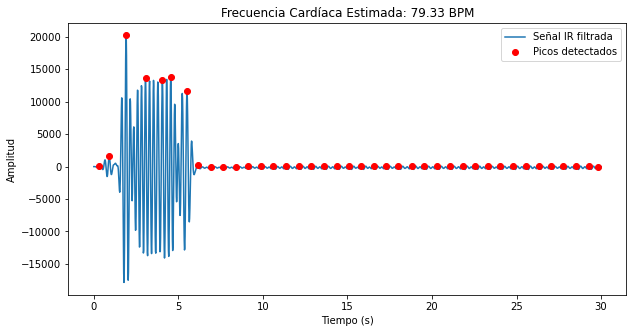

Frecuencia Cardíaca estimada: 79.33 BPM


In [1]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

# Cargar el archivo CSV
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_98_81.csv"
data = pd.read_csv(file_path, decimal='.')

# Extraer columnas
Tiempo = data['Tiempo (ms)'].values  # Tiempo en milisegundos
IR_signal = data['IR'].values  # Señal IR

# Convertir el tiempo a segundos
Tiempo_s = Tiempo / 1000.0

# Filtrado pasa banda (3-5 Hz) con un filtro FIR
fs = 60  # Frecuencia de muestreo estimada
nyquist = fs / 2
lowcut, highcut = 3, 5  # Frecuencias de corte en Hz
numtaps = 101  # Orden del filtro
fir_coeff = signal.firwin(numtaps, [lowcut / nyquist, highcut / nyquist], pass_zero=False)
IR_filtered = signal.lfilter(fir_coeff, 1.0, IR_signal)

# Detección de picos
peaks, _ = signal.find_peaks(IR_filtered, height=np.mean(IR_filtered), distance=fs/2)

# Cálculo de la frecuencia cardíaca
intervalos = np.diff(Tiempo_s[peaks])  # Diferencias entre picos (en segundos)
HR = 60 / np.mean(intervalos) if len(intervalos) > 0 else 0

# Gráfica de la señal con picos detectados
plt.figure(figsize=(10, 5))
plt.plot(Tiempo_s, IR_filtered, label='Señal IR filtrada')
plt.plot(Tiempo_s[peaks], IR_filtered[peaks], 'ro', label='Picos detectados')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title(f"Frecuencia Cardíaca Estimada: {HR:.2f} BPM")
plt.legend()
plt.show()

print(f"Frecuencia Cardíaca estimada: {HR:.2f} BPM")


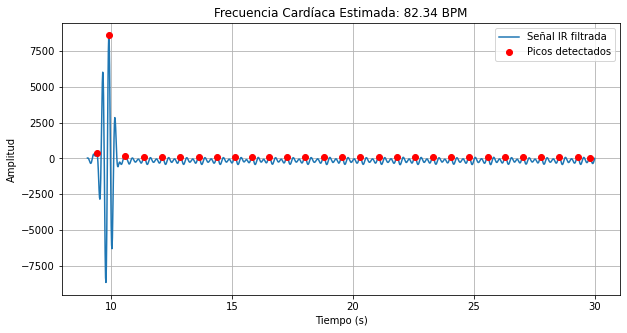

Frecuencia Cardíaca estimada: 82.34 BPM


In [2]:
Tiempo = data['Tiempo (ms)'].values  # Tiempo en milisegundos
IR_signal = data['IR'].values        # Señal IR

# Convertir tiempo a segundos
Tiempo_s = Tiempo / 1000.0

# Recortar los primeros 9 segundos
mask = Tiempo_s >= 9
Tiempo_s = Tiempo_s[mask]
IR_signal = IR_signal[mask]

# Filtrado pasa banda (3–5 Hz) con filtro FIR
fs = 60  # Frecuencia de muestreo estimada
nyquist = fs / 2
lowcut, highcut = 3, 5  # Frecuencias de corte en Hz
numtaps = 101           # Orden del filtro FIR
fir_coeff = signal.firwin(numtaps, [lowcut / nyquist, highcut / nyquist], pass_zero=False)
IR_filtered = signal.lfilter(fir_coeff, 1.0, IR_signal)

# Detección de picos
threshold = np.mean(IR_filtered)
peaks, _ = signal.find_peaks(IR_filtered, height=threshold, distance=fs/2)

# Cálculo de frecuencia cardíaca
intervalos = np.diff(Tiempo_s[peaks])
HR = 60 / np.mean(intervalos) if len(intervalos) > 0 else 0

# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(Tiempo_s, IR_filtered, label='Señal IR filtrada')
plt.plot(Tiempo_s[peaks], IR_filtered[peaks], 'ro', label='Picos detectados')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title(f"Frecuencia Cardíaca Estimada: {HR:.2f} BPM")
plt.legend()
plt.grid(True)
plt.show()

print(f"Frecuencia Cardíaca estimada: {HR:.2f} BPM")

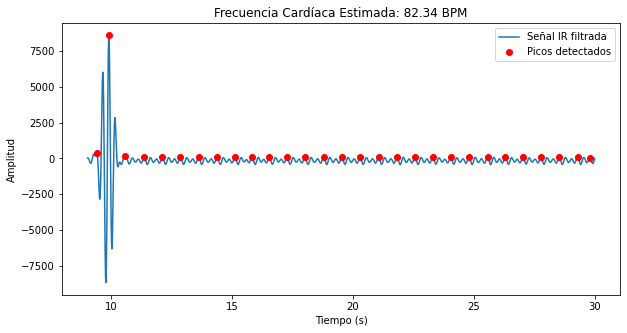

Frecuencia Cardíaca estimada: 82.34 BPM


In [3]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

# Cargar el archivo CSV
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_98_81.csv"
data = pd.read_csv(file_path, decimal=',')

# Extraer columnas
Tiempo = data['Tiempo (ms)'].values  # Tiempo en milisegundos
IR_signal = data['IR'].values  # Señal IR

# Convertir el tiempo a segundos
Tiempo_s = Tiempo / 1000.0

# Eliminar los primeros 9 segundos para reducir el ruido
mask = Tiempo_s >= 9  # Filtrar los datos desde el segundo 5 en adelante
Tiempo_s = Tiempo_s[mask]
IR_signal = IR_signal[mask]

# Filtrado pasa banda (3-5 Hz) con un filtro FIR
fs = 60  # Frecuencia de muestreo estimada (ajustar según corresponda)
nyquist = fs / 2
lowcut, highcut = 3, 5  # Frecuencias de corte en Hz
numtaps = 101  # Orden del filtro
fir_coeff = signal.firwin(numtaps, [lowcut / nyquist, highcut / nyquist], pass_zero=False)
IR_filtered = signal.lfilter(fir_coeff, 1.0, IR_signal)

# Detección de picos
peaks, _ = signal.find_peaks(IR_filtered, height=np.mean(IR_filtered), distance=fs/2)

# Cálculo de la frecuencia cardíaca
intervalos = np.diff(Tiempo_s[peaks])  # Diferencias entre picos (en segundos)
HR = 60 / np.mean(intervalos) if len(intervalos) > 0 else 0

# Gráfica de la señal con picos detectados
plt.figure(figsize=(10, 5))
plt.plot(Tiempo_s, IR_filtered, label='Señal IR filtrada')
plt.plot(Tiempo_s[peaks], IR_filtered[peaks], 'ro', label='Picos detectados')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title(f"Frecuencia Cardíaca Estimada: {HR:.2f} BPM")
plt.legend()
plt.show()

print(f"Frecuencia Cardíaca estimada: {HR:.2f} BPM")



Procesando: raw_data_91_91.csv
Frecuencia Cardíaca estimada: 90.58 BPM


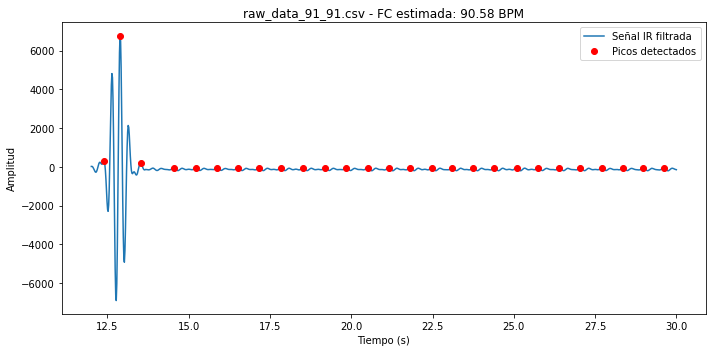


Procesando: raw_data_92_76.csv
Frecuencia Cardíaca estimada: 85.66 BPM


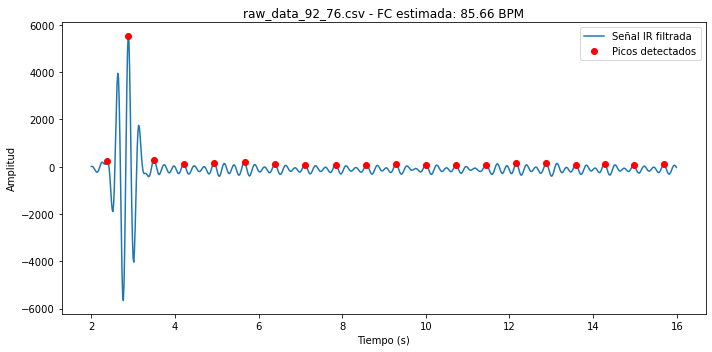


Procesando: raw_data_93_100.csv
Frecuencia Cardíaca estimada: 91.13 BPM


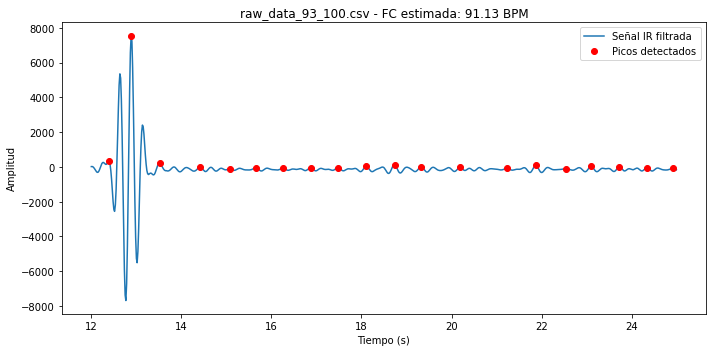


Procesando: raw_data_95_77_2.csv
Frecuencia Cardíaca estimada: 85.77 BPM


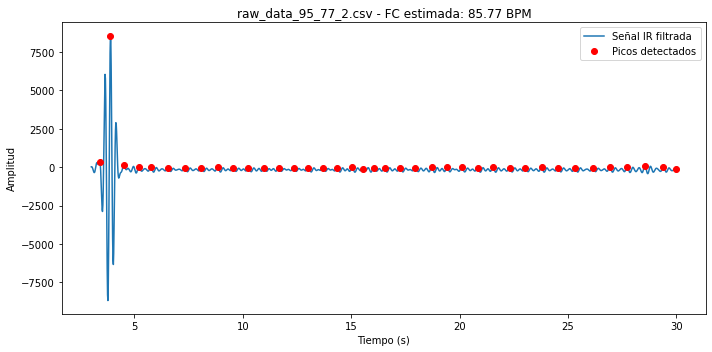


Procesando: raw_data_95_80.csv
Frecuencia Cardíaca estimada: 76.97 BPM


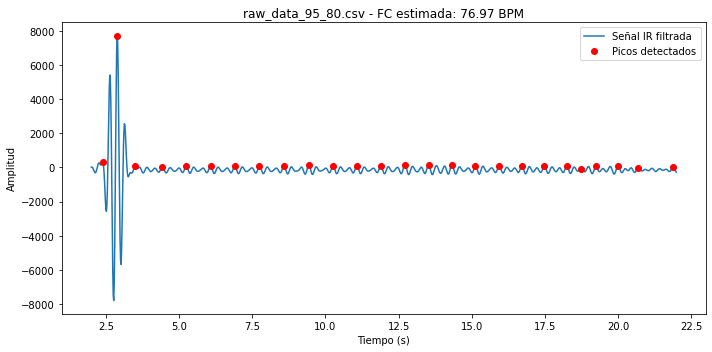


Procesando: raw_data_95_81_papa.csv
Frecuencia Cardíaca estimada: 82.17 BPM


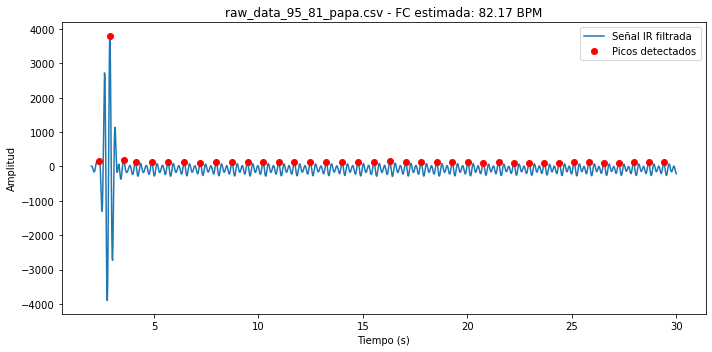


Procesando: raw_data_95_99.csv
Frecuencia Cardíaca estimada: 92.66 BPM


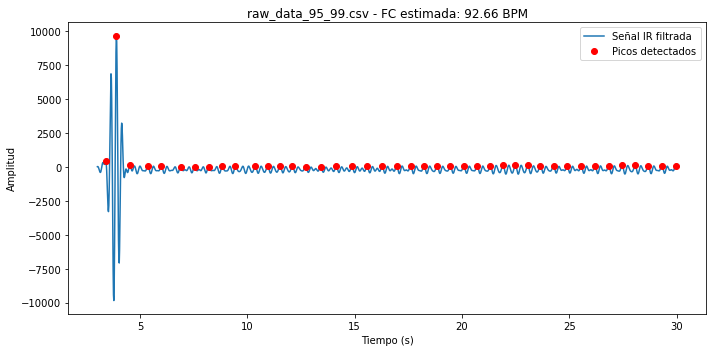


Procesando: raw_data_96_106.csv
Frecuencia Cardíaca estimada: 93.17 BPM


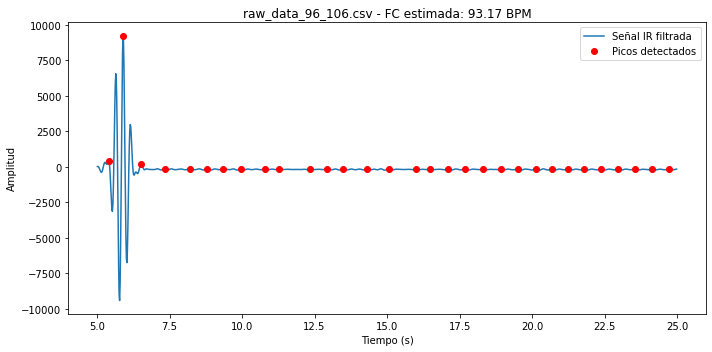


Procesando: raw_data_96_69.csv
Frecuencia Cardíaca estimada: 74.68 BPM


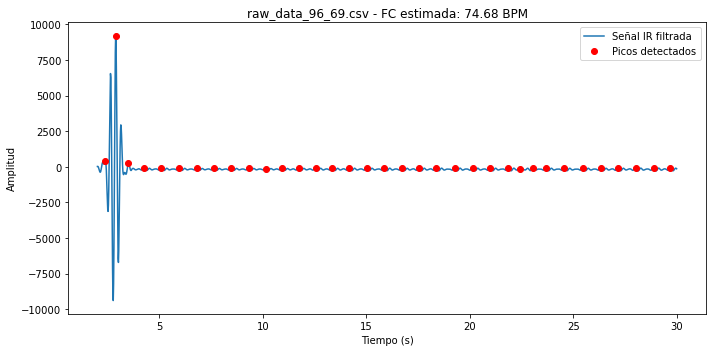


Procesando: raw_data_97_119.csv
Frecuencia Cardíaca estimada: 93.63 BPM


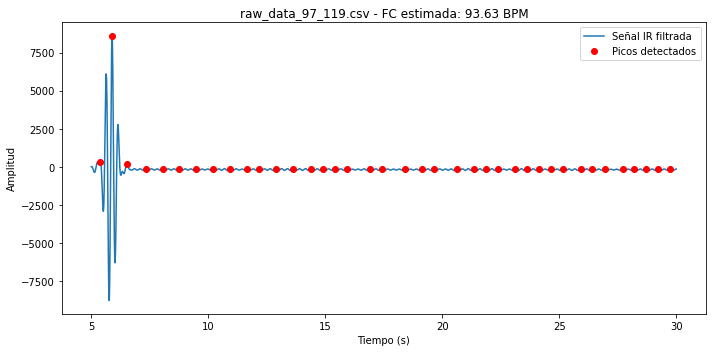


Procesando: raw_data_97_95.csv
Frecuencia Cardíaca estimada: 93.79 BPM


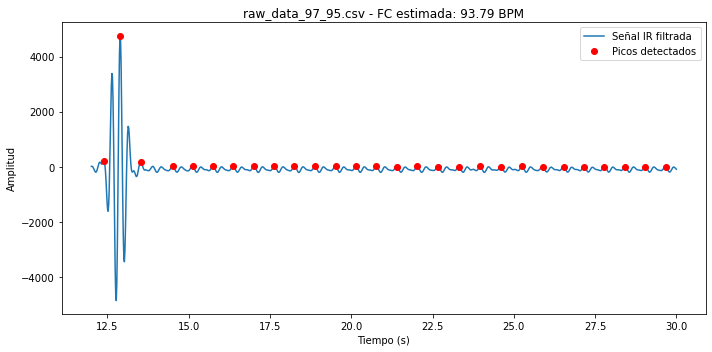


Procesando: raw_data_98_81.csv
Frecuencia Cardíaca estimada: 81.15 BPM


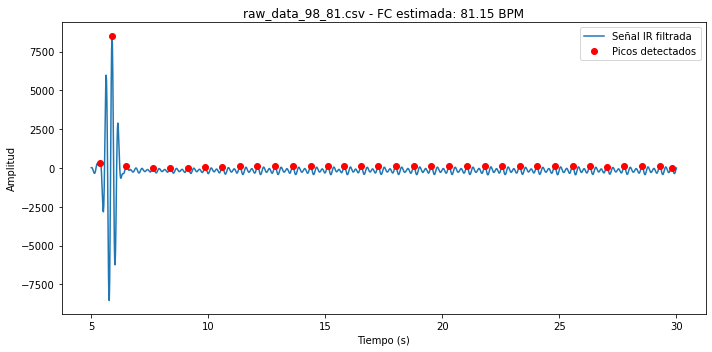


Procesando: raw_data_98_86.csv
Frecuencia Cardíaca estimada: 86.75 BPM


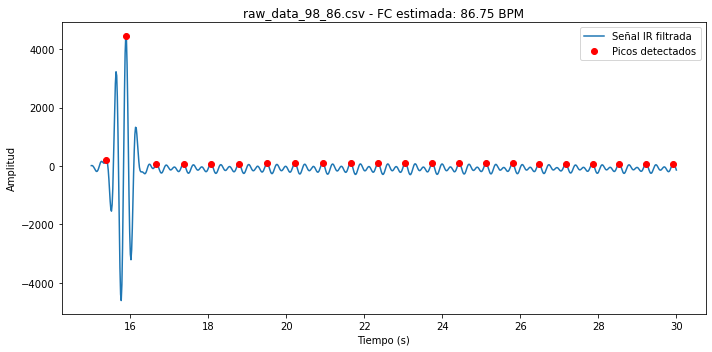


Procesando: raw_data_98_91.csv
Frecuencia Cardíaca estimada: 99.38 BPM


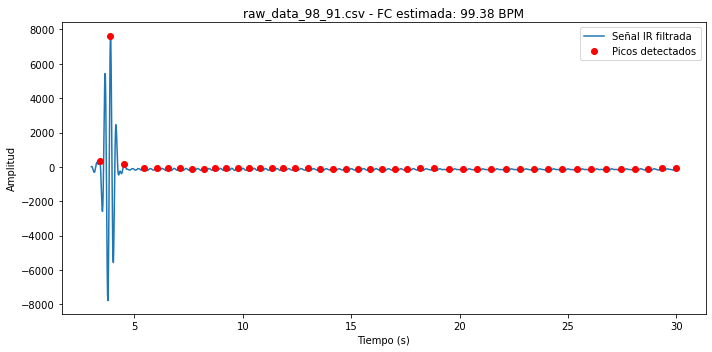


Procesando: raw_data_99_75.csv
Frecuencia Cardíaca estimada: 76.74 BPM


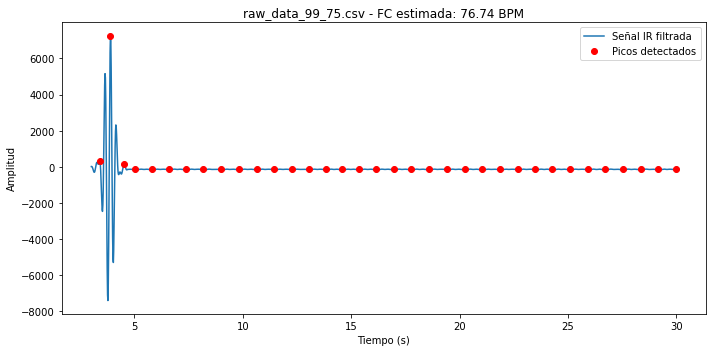


Procesando: raw_data_99_91.csv
Frecuencia Cardíaca estimada: 85.10 BPM


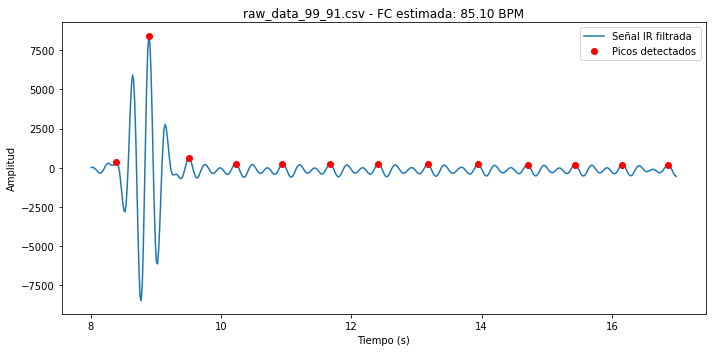

In [4]:
import os
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt

# Ruta con los archivos CSV
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"

# Parámetros del filtro
fs = 60  # Frecuencia de muestreo estimada
nyquist = fs / 2
lowcut, highcut = 3, 5
numtaps = 101
fir_coeff = signal.firwin(numtaps, [lowcut / nyquist, highcut / nyquist], pass_zero=False)

# Procesar cada archivo CSV en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        print(f"\nProcesando: {file_name}")
        
        # Leer los datos
        data = pd.read_csv(file_path, decimal='.')
        
        try:
            Tiempo = data['Tiempo (ms)'].values
            IR_signal = data['IR'].values
        except KeyError:
            print(f"Error: el archivo {file_name} no contiene las columnas esperadas.")
            continue
        
        # Tiempo en segundos
        Tiempo_s = Tiempo / 1000.0

        # Filtrado pasa banda
        IR_filtered = signal.lfilter(fir_coeff, 1.0, IR_signal)

        # Detección de picos
        peaks, _ = signal.find_peaks(IR_filtered, height=np.mean(IR_filtered), distance=fs/2)

        # Cálculo de frecuencia cardíaca
        intervalos = np.diff(Tiempo_s[peaks])
        HR = 60 / np.mean(intervalos) if len(intervalos) > 0 else 0

        # Mostrar resultados
        print(f"Frecuencia Cardíaca estimada: {HR:.2f} BPM")

        # Gráfica
        plt.figure(figsize=(10, 5))
        plt.plot(Tiempo_s, IR_filtered, label='Señal IR filtrada')
        plt.plot(Tiempo_s[peaks], IR_filtered[peaks], 'ro', label='Picos detectados')
        plt.xlabel("Tiempo (s)")
        plt.ylabel("Amplitud")
        plt.title(f"{file_name} - FC estimada: {HR:.2f} BPM")
        plt.legend()
        plt.tight_layout()
        plt.show()


In [5]:
import os
import numpy as np
import pandas as pd
import scipy.signal as signal
import matplotlib.pyplot as plt
import re

# Ruta con los archivos CSV
folder_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos_limpios"
resultados = []

# Parámetros del filtro
fs = 60  # Frecuencia de muestreo estimada
nyquist = fs / 2
lowcut, highcut = 3, 5
numtaps = 101
fir_coeff = signal.firwin(numtaps, [lowcut / nyquist, highcut / nyquist], pass_zero=False)

# Procesar cada archivo CSV en la carpeta
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)

        try:
            data = pd.read_csv(file_path, decimal='.')
            Tiempo = data['Tiempo (ms)'].values
            IR_signal = data['IR'].values
        except KeyError:
            print(f" El archivo {file_name} no contiene columnas esperadas.")
            continue

        # Tiempo en segundos
        Tiempo_s = Tiempo / 1000.0

        # Filtrado FIR
        IR_filtered = signal.lfilter(fir_coeff, 1.0, IR_signal)

        # Detección de picos
        peaks, _ = signal.find_peaks(IR_filtered, height=np.mean(IR_filtered), distance=fs/2)

        # Cálculo de frecuencia cardíaca
        intervalos = np.diff(Tiempo_s[peaks])
        HR = 60 / np.mean(intervalos) if len(intervalos) > 0 else np.nan

        # FC esperada desde el nombre
        match = re.match(r".*_(\d+)_(\d+)", file_name)
        expected_hr = int(match.group(2)) if match else None

        resultados.append({
            "Archivo": file_name,
            "FC esperada (bpm)": expected_hr,
            "FC estimada (bpm)": round(HR, 2) if not np.isnan(HR) else "Error"
        })

# Crear tabla
tabla = pd.DataFrame(resultados)
print(tabla)

# Guardar CSV
csv_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados\resultados_FIR.csv"
tabla.to_csv(csv_path, index=False)

# Guardar imagen
fig, ax = plt.subplots(figsize=(11, len(tabla) * 0.5 + 1))
ax.axis('off')
tabla_img = ax.table(cellText=tabla.values,
                     colLabels=tabla.columns,
                     cellLoc='center',
                     loc='center')
tabla_img.auto_set_font_size(False)
tabla_img.set_fontsize(10)
tabla_img.scale(1, 1.5)

png_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Código\resultados\resultados_FIR.png"
plt.savefig(png_path, bbox_inches='tight', dpi=300)
plt.close()


                    Archivo  FC esperada (bpm)  FC estimada (bpm)
0        raw_data_91_91.csv                 91              90.58
1        raw_data_92_76.csv                 76              85.66
2       raw_data_93_100.csv                100              91.13
3      raw_data_95_77_2.csv                  2              85.77
4        raw_data_95_80.csv                 80              76.97
5   raw_data_95_81_papa.csv                 81              82.17
6        raw_data_95_99.csv                 99              92.66
7       raw_data_96_106.csv                106              93.17
8        raw_data_96_69.csv                 69              74.68
9       raw_data_97_119.csv                119              93.63
10       raw_data_97_95.csv                 95              93.79
11       raw_data_98_81.csv                 81              81.15
12       raw_data_98_86.csv                 86              86.75
13       raw_data_98_91.csv                 91              99.38
14       r